---
DEEP REINFORCEMENT LEARNING EXPLAINED - 19
# **Policy-Gradient Methods**
### REINFORCE Algorithm
---


Import packages

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import time
torch.manual_seed(0) # set random seed


OpenAI Gym's Cartpole Environment

In [2]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
env = gym.make("LunarLander-v2")
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold: ', env.spec.reward_threshold)


observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
threshold:  200


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Model

In [4]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  
HIDDEN_SIZE = 256

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=4, bias=True)
  (3): Softmax(dim=0)
)


The REINFORCE training loop

In [5]:
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Horizon = 500
MAX_TRAJECTORIES = 5000
gamma = 0.99
score = [] 

for trajectory in range(MAX_TRAJECTORIES):
    curr_state = env.reset()
    done = False
    transitions = [] 
    
    for t in range(Horizon):
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1,2,3]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) 
        transitions.append((prev_state, action, t+1)) 
        if done: 
            break
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) 

    batch_Gvals =[]
    for i in range(len(transitions)):
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    
    
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) 

    pred_batch = model(state_batch) 
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() 
    
    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory>0:
            torch.save(model.state_dict(), 'checkpoint.pth')
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

    if np.mean(score[-50:-1]) >= 200:
      break

<ipython-input-5-57cf5d18c6f1>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state_batch = torch.Tensor([s for (s,a,r) in transitions])
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trajectory 50	Average Score: 92.47
Trajectory 100	Average Score: 95.90
Trajectory 150	Average Score: 92.51
Trajectory 200	Average Score: 93.06
Trajectory 250	Average Score: 93.94
Trajectory 300	Average Score: 102.51
Trajectory 350	Average Score: 109.31
Trajectory 400	Average Score: 107.47
Trajectory 450	Average Score: 129.94
Trajectory 500	Average Score: 154.02
Trajectory 550	Average Score: 168.86
Trajectory 600	Average Score: 160.00


Plot the Scores

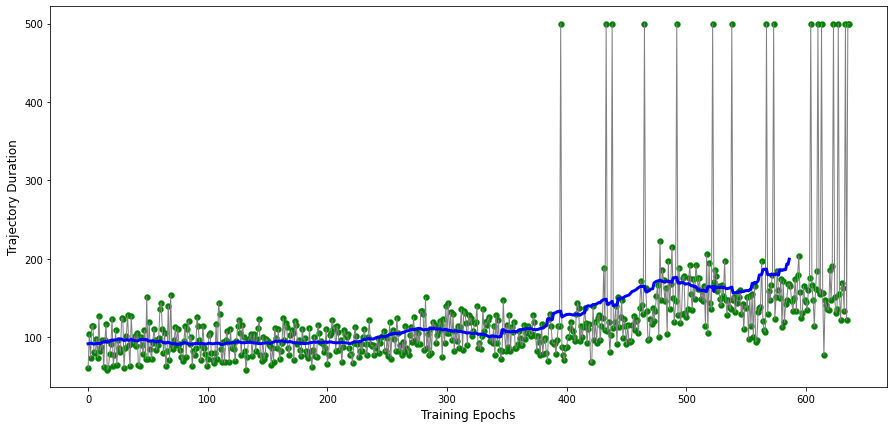

In [6]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [7]:
#!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [14]:
import pygame
from gym.wrappers.monitoring.video_recorder import VideoRecorder


def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="./{}.mp4".format(env_name))
    agent.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        
        act_prob = model(torch.from_numpy(state).float())
        action = np.random.choice(np.array([0,1,2,3]), p=act_prob.data.numpy())

        state, reward, done, _ = env.step(action)        
    env.close()

In [15]:
show_video_of_model(model, 'LunarLander-v2')

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
